# Libraries and Tools

In [1]:
from utils import *
from student_utils import *
import gurobipy as grb
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Graph Class

In [2]:
"""
A class that performs data preprocessing to gather important data and to provide useful functions
"""
class Graph:
    def __init__(self, input_file):
        parsed_data = data_parser(read_file(input_file))
        self.data = {}
        self.input_file = input_file
        self.number_of_locations = parsed_data[0] 
        self.number_of_houses = parsed_data[1] 
        self.list_of_locations = parsed_data[2]  
        self.list_of_houses = parsed_data[3] 
        self.starting_location = parsed_data[4] 
        self.adjacency_matrix = parsed_data[5] 
        self.G, message = adjacency_matrix_to_graph(self.adjacency_matrix)
        if message:
            print(message)
        else:
            print("Successful creation of Graph instance")
        
    """
    Returns a NumPy matrix of shortest path distances between every pair of nodes using the Floyd-Warshall algorithm. 
    If there is no path between to nodes the corresponding matrix entry will be Inf.
    """
    def get_fw_matrix(self):
        return nx.floyd_warshall_numpy(self.G)

In [3]:
graph = Graph("inputs/practice.in")

Successful creation of Graph instance


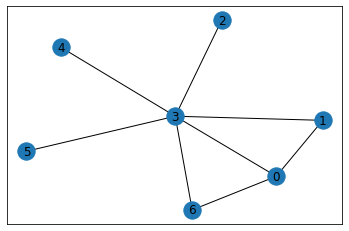

In [4]:
nx.draw_networkx(graph.G)

# Integer Linear Programming

In [5]:
model = grb.Model()

Academic license - for non-commercial use only


In [6]:
""" Arrangement of Drop-Offs Matrix """
ARRANGEMENTS = []
for r in range(graph.number_of_locations):
    ROW = []
    for c in range(graph.number_of_houses + 2):
        matrix_element_name = "A_" + str(r) + "_" + str(c)
        ROW.append(model.addVar(vtype=grb.GRB.BINARY, name=matrix_element_name))
        model.update()
    ARRANGEMENTS.append(ROW)
ARRANGEMENTS = np.array(ARRANGEMENTS)

""" Arrangement of Drop-Offs Constraints """
# Get the index number of where Soda is
soda = graph.list_of_locations.index(graph.starting_location)
# Check that we start at Soda
model.addConstr(ARRANGEMENTS[soda][0] == 1)
# Check that we end at Soda
model.addConstr(ARRANGEMENTS[soda][graph.number_of_houses + 1] == 1)
# Check that each column of ARRANGEMENTS sums up to 1
for c in range(len(ARRANGEMENTS[0])):
    model.addConstr(grb.quicksum(ARRANGEMENTS[:, c]) == 1)

In [7]:
""" TA Walking Matrix """
WALKING = []
for r in range(graph.number_of_locations):
    ROW = []
    for c in range(graph.number_of_locations):
        matrix_element_name = "W_" + str(r) + "_" + str(c)
        ROW.append(model.addVar(vtype=grb.GRB.BINARY, name=matrix_element_name))
        model.update()
    WALKING.append(ROW)
WALKING = np.array(WALKING)

In [8]:
""" TA Walking Constraints """
H = (np.array(convert_locations_to_indices(graph.list_of_locations, graph.list_of_houses)) != None).astype(int)

# Check that each column i of WALKING sums up to H[i]
for i in range(len(WALKING[0])):
    model.addConstr(grb.quicksum(WALKING[:, i]) == H[i])
    
# 0:Soda, 1:Dwinelle, 2:Wheeler, 3:Campanile, 4:Cory, 5:RSF, 6:Barrows
# Homes: Wheeler Campanile Cory RSF

for vertex in range(len(WALKING)):
    model.addConstr(grb.quicksum(WALKING[vertex,1:]) == grb.quicksum(ARRANGEMENTS[vertex,1:len(WALKING[0]) - 2]))

In [9]:
ARRANGEMENTS[0,1:len(WALKING[0]) - 2], ARRANGEMENTS[0]

(array([<gurobi.Var A_0_1>, <gurobi.Var A_0_2>, <gurobi.Var A_0_3>,
        <gurobi.Var A_0_4>], dtype=object),
 array([<gurobi.Var A_0_0>, <gurobi.Var A_0_1>, <gurobi.Var A_0_2>,
        <gurobi.Var A_0_3>, <gurobi.Var A_0_4>, <gurobi.Var A_0_5>],
       dtype=object))

In [10]:
""" Driving Cost Function """
DISTANCES = graph.get_fw_matrix()
driving_cost_function = []
for c in range(graph.number_of_houses + 1):
    summation = []
    for i in range(graph.number_of_locations):
        for j in range(graph.number_of_locations):
            summation.append(
                grb.QuadExpr(ARRANGEMENTS[i][c] * DISTANCES.item((i, j)) * ARRANGEMENTS[j][c + 1])
            )
            model.update()
    driving_cost_function.append(grb.quicksum(summation))
    
""" Walking Cost Function """
walking_cost_function = []
for row in range(graph.number_of_locations):
    for col in range(graph.number_of_locations):
        walking_cost_function.append(grb.LinExpr(WALKING[row][col] * DISTANCES.item((row, col))))
        model.update()
        
""" Set Objective Function """
cost_function = driving_cost_function + walking_cost_function
model.setObjective(grb.quicksum(cost_function), grb.GRB.MINIMIZE)

""" Minimize Objective Function """
model.optimize()

Optimize a model with 22 rows, 91 columns and 163 nonzeros
Model has 210 quadratic objective terms
Variable types: 0 continuous, 91 integer (91 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  QObjective range [2e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 13.0000000
Presolve removed 7 rows and 35 columns
Presolve time: 0.00s
Presolved: 141 rows, 182 columns, 490 nonzeros
Variable types: 0 continuous, 182 integer (182 binary)

Root relaxation: objective 3.000000e+00, 23 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.00000    0    8   13.00000    3.00000  76.9%     -    0s
H    0     0                       9.0000000    3.00000  66.7%     -    0s
     0     0    3.00000    0   12    9.00000    3.00000  66.7%     -    0

In [11]:
A = []
for v in model.getVars():
    if v.VarName[0] == 'A':
        A.append(v.x)

A_matrix = np.array(A).reshape((graph.number_of_locations, graph.number_of_houses + 2))
A_matrix

array([[ 1., -0., -0., -0., -0.,  1.],
       [ 0.,  0., -0., -0.,  0.,  0.],
       [ 0., -0.,  0.,  0., -0.,  0.],
       [ 0.,  1.,  1.,  1.,  1.,  0.],
       [ 0., -0.,  0.,  0., -0.,  0.],
       [ 0., -0.,  0.,  0., -0.,  0.],
       [ 0.,  0., -0., -0.,  0.,  0.]])

In [12]:
W = []
for v in model.getVars():
    if v.VarName[0] == 'W':
        W.append(v.x)

W_matrix = np.array(W).reshape((graph.number_of_locations, graph.number_of_locations))
W_matrix

array([[ 0.,  0., -0., -0., -0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -0., -0., -0.,  0.],
       [ 0.,  0.,  1.,  1.,  1.,  1.,  0.],
       [ 0.,  0., -0., -0.,  0., -0.,  0.],
       [ 0.,  0., -0., -0., -0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])